# 把框选出的单词单独保存出来

In [21]:
import os
from os.path import join
import torch
from PIL import Image
import torchvision.transforms as transforms

def crop_words_from_pt_label(data_path, label_file, max_size=(100, 100)):
    """Crop words from images using bounding boxes provided in a .pt label file."""
    label_data = torch.load(label_file)
    cropped_words = []

    for entry in label_data:
        if isinstance(entry, tuple) and len(entry) == 4:
            img_filename = entry[0]
            binary_image = entry[1]
            bounding_boxes = entry[2]
            centroids = entry[3]

            if isinstance(bounding_boxes, (list, tuple)) and len(bounding_boxes) > 0:
                img_path = join(data_path, img_filename)
                image = Image.open(img_path).convert('L')  # Load image in grayscale

                for bbox in bounding_boxes:
                    if len(bbox) == 5:  # Assuming bbox is (x, y, width, height, area)
                        x, y, w, h, area = bbox
                        if area > 10:  # Adjust threshold as needed
                            cropped_word = image.crop((x, y, x + w, y + h))
                            cropped_words.append(transforms.ToTensor()(cropped_word))
                        else:
                            print(f"Ignoring small area bounding box: {bbox}")
                    else:
                        print(f"Ignoring invalid bounding box: {bbox}")
            else:
                print(f"Ignoring invalid or empty bounding boxes: {bounding_boxes}")
        else:
            print(f"Invalid entry found: {entry}. Skipping.")

    # Pad all cropped words to the fixed size
    cropped_words = pad_images(cropped_words, max_size)
    
    return cropped_words

def pad_images(images, max_size=(100, 100)):
    """Pad images to a fixed size."""
    padded_images = []
    for img in images:
        # Get current dimensions
        _, h, w = img.shape
        
        # Calculate padding
        pad_h = max_size[0] - h
        pad_w = max_size[1] - w
        
        # Apply padding
        padded_img = torch.nn.functional.pad(img, (0, pad_w, 0, pad_h), "constant", 0)
        padded_images.append(padded_img)
    return padded_images

In [22]:
CVL_path = '/root/autodl-tmp/APS360_Project/Machine_Learning_Output/output/CVL'
CVL_label_path = '/root/autodl-tmp/APS360_Project/Machine_Learning_Output/binary_image_bounding_box/CVL_seg_connected_components.pt'
CVL_save_path = '/root/autodl-tmp/APS360_Project/Machine_Learning_Output/output/CVL_rec/CVL_rec.pt'

# Process images and save cropped words
cropped_words = crop_words_from_pt_label(CVL_path, CVL_label_path, max_size = (100,100))
cropped_words_tensor = torch.stack(cropped_words)
torch.save(cropped_words_tensor, CVL_save_path)

Ignoring invalid or empty bounding boxes: [[     0      0   1024   1024 989300]
 [   124     85     21     59    211]
 [   184     87     15     39    139]
 ...
 [   255    911     38     25    190]
 [   147    915     64     21    347]
 [   353    930      5      6     18]]
Ignoring invalid or empty bounding boxes: [[      0       0    1024    1024 1009627]
 [    308     259      30      55     406]
 [    212     260      31      54     342]
 [     61     262      55      48     499]
 [    350     262      52      53     610]
 [    733     264      47      57     591]
 [     21     266      36      50     365]
 [    471     268      27      51     283]
 [    269     274      21      35     158]
 [    617     274      33      48     288]
 [    427     277      10       7      30]
 [    687     276      37      59     289]
 [    542     280      49      41     621]
 [    533     283       6       4      17]
 [    779     282       1       1       1]
 [    136     286      54      30    

RuntimeError: stack expects a non-empty TensorList

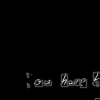

In [11]:
def load_and_display_sample(pt_file_path, index=0):
    """Load a .pt file and display one sample image."""
    cropped_words_tensor = torch.load(pt_file_path)
    sample_image_tensor = cropped_words_tensor[index]
    
    # Convert tensor to PIL image and display
    sample_image = transforms.ToPILImage()(sample_image_tensor)
    sample_image.show()

load_and_display_sample(CVL_save_path, index=0)